Loading datasets...
Initializing model...
Total number of trainable parameters: 1,130,496
Starting training...
Using device: cpu
Epoch [1/40], Batch [0/240], Loss: 0.693084
Epoch [1/40], Batch [50/240], Loss: 0.267575
Epoch [1/40], Batch [100/240], Loss: 0.243108
Epoch [1/40], Batch [150/240], Loss: 0.196229
Epoch [1/40], Batch [200/240], Loss: 0.178790
Epoch [1/40], Average Loss: 0.236914
Epoch [2/40], Batch [0/240], Loss: 0.166381
Epoch [2/40], Batch [50/240], Loss: 0.148780
Epoch [2/40], Batch [100/240], Loss: 0.148558
Epoch [2/40], Batch [150/240], Loss: 0.137354
Epoch [2/40], Batch [200/240], Loss: 0.135027
Epoch [2/40], Average Loss: 0.141230
Epoch [3/40], Batch [0/240], Loss: 0.131535
Epoch [3/40], Batch [50/240], Loss: 0.126219
Epoch [3/40], Batch [100/240], Loss: 0.122359
Epoch [3/40], Batch [150/240], Loss: 0.114865
Epoch [3/40], Batch [200/240], Loss: 0.116880
Epoch [3/40], Average Loss: 0.119801
Epoch [4/40], Batch [0/240], Loss: 0.111097
Epoch [4/40], Batch [50/240], Loss:

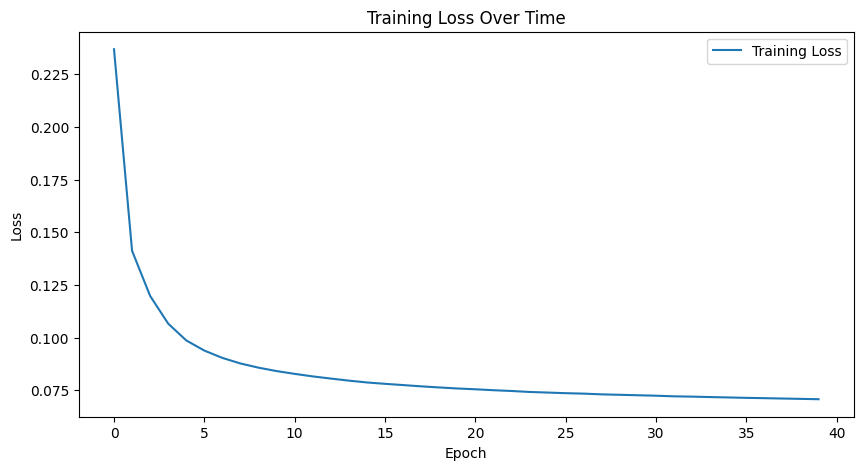

Evaluating model...
Average Test Loss: 0.071386
Generating reconstructions...


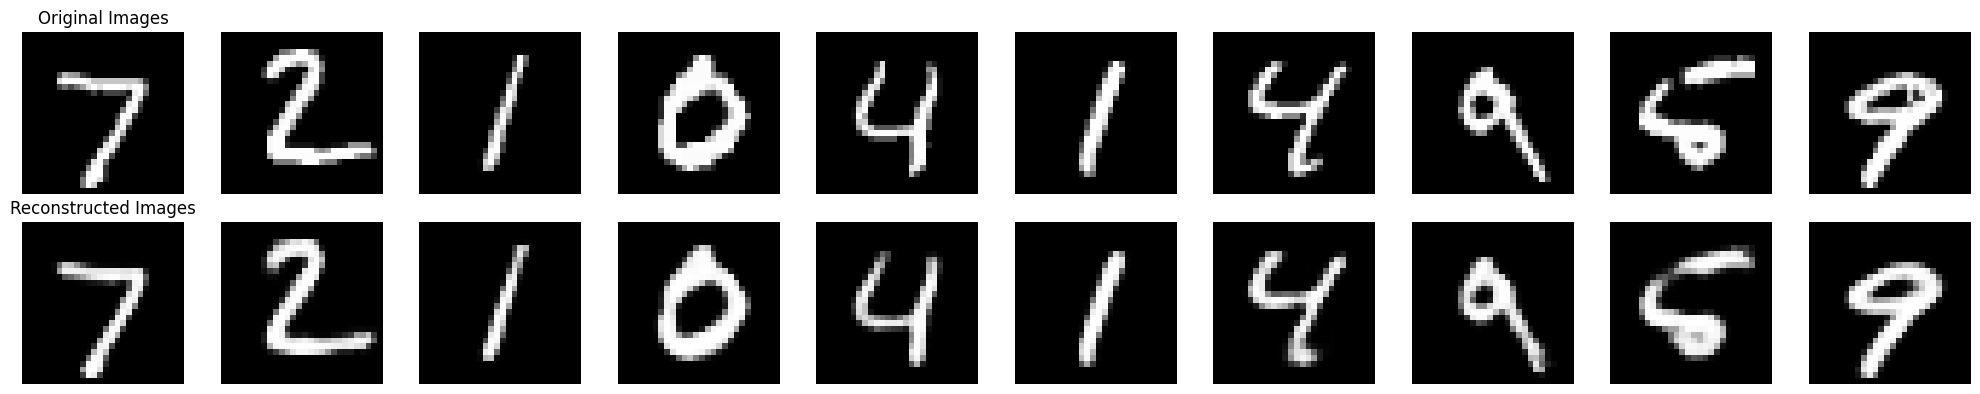

Visualizing latent space...


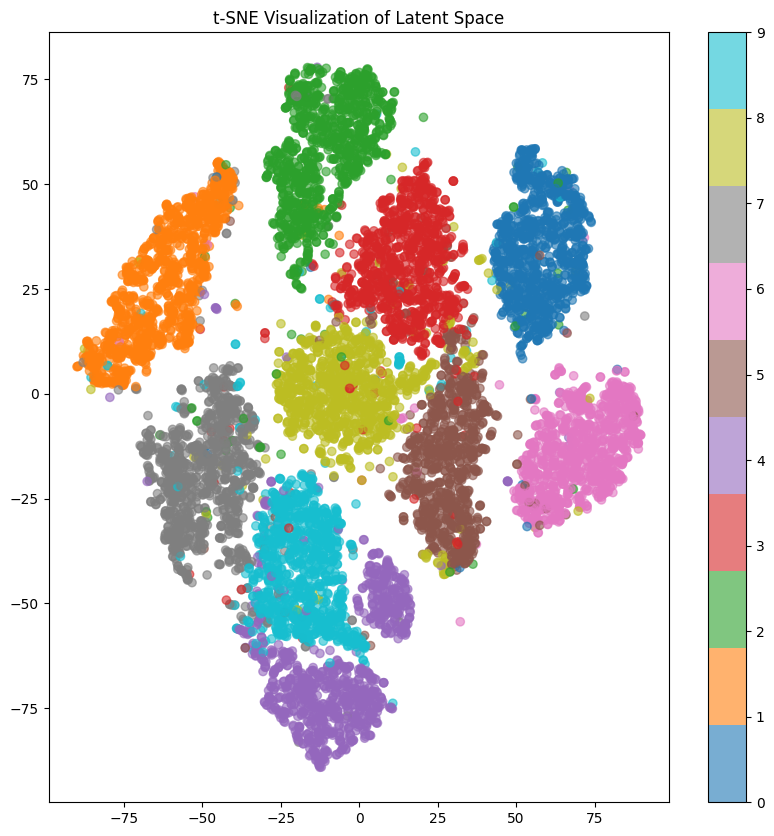

Saving model...
All tasks completed!


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


def set_seed(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
        try:
            torch.cuda.manual_seed(seed)
        except RuntimeError:
            print("Warning: Could not set CUDA seed. Continuing with CPU only.")
            torch.cuda.is_available = lambda: False


class MNISTDataset(Dataset):
    def __init__(self, csv_file):
        data = pd.read_csv(csv_file)

        # Separate labels and features
        self.labels = data.iloc[:, 0].values
        self.features = data.iloc[:, 1:].values

        # Convert to float32 and normalize
        self.features = self.features.astype(np.float32) / 255.0

        # Convert to tensors
        self.features = torch.FloatTensor(self.features)
        self.labels = torch.LongTensor(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


class ThreeLayerAutoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256], latent_size=128):
        super(ThreeLayerAutoencoder, self).__init__()

        self.input_size = input_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0], bias=False),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1], bias=False),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], latent_size, bias=False)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_sizes[1], bias=False),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[0], bias=False),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], input_size, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        x = x.view(x.size(0), -1)
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def train_model(model, train_loader, num_epochs=40, learning_rate=0.001):
    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
    except RuntimeError:
        print("Warning: CUDA error detected. Falling back to CPU.")
        device = torch.device("cpu")
        model = model.to(device)

    print(f"Using device: {device}")

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            try:
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data.view(data.size(0), -1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if batch_idx % 50 == 0:
                    print(
                        f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.6f}')

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                if "CUDA" in str(e):
                    print("CUDA error detected. Falling back to CPU.")
                    device = torch.device("cpu")
                    model = model.to(device)
                continue

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss:.6f}')

    return train_losses


def visualize_reconstructions(model, test_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        images, _ = next(iter(test_loader))
        images = images[:num_images]

        # Get reconstructions
        reconstructions = model(images)

        # Reshape back to images
        images = images.view(-1, 28, 28)
        reconstructions = reconstructions.view(-1, 28, 28)

        # Plot original and reconstructed images
        plt.figure(figsize=(20, 4))
        for i in range(num_images):
            # Original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Original Images')

            # Reconstructed
            plt.subplot(2, num_images, i + num_images + 1)
            plt.imshow(reconstructions[i], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed Images')

        plt.tight_layout()
        plt.show()


def plot_training_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()


def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for data, _ in test_loader:
            output = model(data)
            loss = criterion(output, data.view(data.size(0), -1))
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f'Average Test Loss: {avg_loss:.6f}')
    return avg_loss


def visualize_latent_space(model, test_loader):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, label in test_loader:
            latent = model.encode(data)
            latent_vectors.append(latent)
            labels.append(label)

    latent_vectors = torch.cat(latent_vectors, dim=0)
    labels = torch.cat(labels, dim=0)

    # Use t-SNE to reduce dimensionality to 2D for visualization
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors.numpy())

    # Plot
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                         c=labels.numpy(), cmap='tab10',
                         alpha=0.6)
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of Latent Space')
    plt.show()


def main():
    # Set seeds
    set_seed(42)

    # Hyperparameters
    BATCH_SIZE = 250
    HIDDEN_SIZES = [512, 256]
    LATENT_SIZE = 128
    NUM_EPOCHS = 40

    # Load datasets
    print("Loading datasets...")
    train_dataset = MNISTDataset('mnist_train.csv')
    test_dataset = MNISTDataset('mnist_test.csv')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model
    print("Initializing model...")
    model = ThreeLayerAutoencoder(hidden_sizes=HIDDEN_SIZES, latent_size=LATENT_SIZE)

    # Print model parameter count
    num_params = model.count_parameters()
    print(f"Total number of trainable parameters: {num_params:,}")

    # Train model
    print("Starting training...")
    train_losses = train_model(model, train_loader, NUM_EPOCHS)

    # Plot training loss
    print("Plotting training loss...")
    plot_training_loss(train_losses)

    # Evaluate model
    print("Evaluating model...")
    test_loss = evaluate_model(model, test_loader)

    # Generate reconstructions
    print("Generating reconstructions...")
    visualize_reconstructions(model, test_loader)

    # Visualize latent space
    print("Visualizing latent space...")
    visualize_latent_space(model, test_loader)

    # Save model
    print("Saving model...")
    torch.save(model.state_dict(), 'autoencoder_model.pth')

    print("All tasks completed!")


if __name__ == "__main__":
    main()